In this course we use a number of Python packages to "train," or fit, and evaluate various kinds of predictive models.  

Current "big hitter" packages include [Scikit Learn](http://scikit-learn.org/stable/) and [StatsModels](http://www.statsmodels.org/stable/).  In the following exercise, we're going to use some methods provided in the latter to estimate and evaluate a simple linear regression model.  Our model predict a continuous dependent ('Y') variable using a weighted linear combination of predictor ('X') variables.  The weights, or regression coefficients, are unknown quantities that we want to estimate by specifying a model and using the available data.

In other parts of this course we'll be using [Scikit Learn](http://scikit-learn.org/stable/) quite a bit.  

[StatsModels](http://www.statsmodels.org/stable/) provide a very large number of statistical methods, as can be seen by perusing its [modules list](http://www.statsmodels.org/stable/py-modindex.html).

In addition to using [StatsModels](http://www.statsmodels.org/stable/) methods, we'll use some other packages that are frequently used when using Python for data science.  

What follows is a regression with Python "warm-up," and probably also a linear regression review for many of you.

### Python packages

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import seaborn as sns

# The following allows multiple outputs in a single output cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Here's where you can learn about these packages:  
* [Pandas](https://pandas.pydata.org)  
* [Numpy](http://www.numpy.org)  
* [matplotlib](https://matplotlib.org)

A lesser known but often useful package for summarizing a pandas DataFrame is [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling).  (Like any other Python package, it must be installed before it can be imported into a Python session.)

In [6]:
# These will mute warnings that may be result from importing pandas-profiling
import warnings
warnings.filterwarnings('ignore')  
# A risky thing to do, generally speaking. Remove if you're nervous.

In [7]:
import pandas_profiling as profile # Note the_ (underscore), is not a - (dash).  

ModuleNotFoundError: No module named 'pandas_profiling'

In [8]:
warnings.resetwarnings()  # Resets 'em to defaults

### Data

Our example data are responses to a satisfaction survey administered to patients at a community hospital.  The are in the file DECART-patSat.csv, a comma-delimited csv file with a header record of variable names.  

The survey asked recently discharged inpatients to evaluate various aspects of their care experiences.  The aspects had been determined previously using qualitative research and with reference to the literature on patient satisfaction. Patients' perceptions on the aspects were captured on 11 points, 0 to 10 ratings scales.

The variables in the file are:  

| var name | item                 | rating scale  |
| :--------| :--------------------| :-------------|
| caseID   | respondent number    |  NA
|   sat    | overall satisfaction | 1 = very dissat, 10 = very sat
|   q2     | nurses listened      | 1 = never, 10 = always
|   q3     | nurses explained     | 1 = never, 10 = always
|   q4     | staff courteous      | 1 = never, 10 = always
|   q5     | meals appetizing     | 1 = never, 10 = always
|   q6     | doctors listened     | 1 = never, 10 = always
|   q7     | doctors explained    | 1 = never, 10 = always
|   q8     | staff responsive     | 1 = not at all, 10 = extremely
|   q9     | room was comfortable | 1 = not at all, 10 = extremely
| ptCat    | patient category     | 1= surg, 1 = med, 2 = concierge

We'll be using `sat` as our Y variable in our little example here, and the variables `q2`, `q6`, and `patCat` as our X's.   

Let's input the data into a Pandas DataFrame:

In [10]:
patSatDF=pd.read_csv('DECART-patSat.csv')  # Modify as required

In [11]:
# The shape, column names, and variable types of this DataFrame
patSatDF.shape
patSatDF.columns
patSatDF.dtypes

(1811, 11)

Index(['caseID', 'patSat', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
       'ptCat'],
      dtype='object')

caseID    int64
patSat    int64
q2        int64
q3        int64
q4        int64
q5        int64
q6        int64
q7        int64
q8        int64
q9        int64
ptCat     int64
dtype: object

### Getting a Look at The Data

Let's grab just the variables we want to use from what we input from the csv file, and then "profile" them for a look.

In [ ]:
patSatDF2=patSatDF[['patSat','q2','q6','ptCat']]

We could view the profile report for this DataFrame here in Jupyter, but let's send it to an html file just in case it's length exceeds some limit here in the Notebook.

In [12]:
patSatProfile=profile.ProfileReport(patSatDF2)
patSatProfile.to_file('patSatProfile.html')  # To your current working dir

NameError: name 'profile' is not defined

Take a look at the html file using your browser.

The variables `patSat` and `q2` through `q9` might be considered to be continuous measures with equal interval scales.  `ptCat` is not.  It's best considered to have unordered categories, an "nominal" measure.  We'll take this into account when we estimate a regression model, as follows.  

Note that a usual exploratory data analysis (EDA) practice is to examine plots like scatterplots to discern unusual or unexpected data behavior.  We're going to forgo such EDA activities here.  Suffice it to say that the variables of interest have some dispersion.  (If they didn't, the couldn't be correlated with each other.)

__QUESTION:__ How else would you examine this data to discover features that you didn't expect, or that may inform you about models you may want to fit to it?


It's common machine learning practice to set aside a random subset of cases for use in checking for overfitting. Data sets that are "large enough" are usually split into "train" and "test" random subsamples.  The train subsample is used for model estimation, and the test subsample for assessing overfitting.   `scikit-learn` has methods for randomly splitting data. `Pandas` has ways of subsetting its data objects. But here we're going to use `numpy` and a bit of code to randomly split the cases in patSatDF2.

In [ ]:
np.random.seed(3)  # setting the seed just in case repeatability is needed.
#patSatDF2.loc[:,'train']=pd.Series(np.random.random(len(patSatDF2))<=0.80)
patSatDF2=patSatDF2.assign(train=pd.Series(np.random.random(len(patSatDF2))<=0.80))
patSatTrain=patSatDF2[patSatDF2.train==True]
patSatTest=patSatDF2[patSatDF2.train!=True]
print('Number of train subsample number of records: ',len(patSatTrain))
print('Number of test subsample number of records: ',len(patSatTest))

### A Simple Linear Regression Model

Here's the model we're going estimate:

$$\large{{patSat_i = \hat{\beta}_0 + \hat{\beta}_1 q2 + \hat{\beta}_2 q6 + \hat{\beta}_3ptCat_1+\hat{\beta}_4ptCat_2+\hat{\epsilon}_i}}$$


This is the model for each and every patient "i."  It's linear in its parameters.  Note that there are _two_ predictor variables for `ptCat`.  This unordered categorical variable has three possible values, 0,1, and 2.  Hence we can only get two independent coefficient estimates for it.  There are two degrees of freedom, two df. 

The $\hat{\beta}$'s are the parameters to be estimated. $\hat{\beta}_{0}$ is a coefficient for an intercept term. $\epsilon_i$ is estimated given the value of $patSat_i$ and the estimated value of the RHS before $\epsilon_i$, the "structural" part of the RHS.


The structure, or functional form, of this model implies particular assumptions that can be assessed given a particular set of data.  For example, the ${\epsilon_{i}}'s$ are uncorrelated with the X variables.

A common assumption is:

$$\large{{\epsilon_{i} \sim i.i.d. \, N(0,\sigma^{2}_{\epsilon})}}$$

The ${\epsilon_i}'s$ are independently and identically distributed as Normal with mean zero and variance $\sigma^{2}_{\epsilon}$.  

The assumptions are particularly important if you want to interpret the $\hat{\beta}$'s.  

__QUESTION:__ What other assumptions are indicated by this model's functional form?

Let's estimate this model's parameters using the test subsample.  We'll use ordinary least squares, "OLS," to do it.

### Model Estimation ("Training")

But first, before we start OLS'ing, we need to specify how we're going to use those two df for the `patCat` categorical X variable.  We can get our two possible predictors of this variable for our regression equation in a couple of different ways.  

[StatsModels](http://www.statsmodels.org/stable/contrasts.html?highlight=coding%20categorical) provides convenient ways to use some alternative methods for coding categorical variables.  Here we're going to use what `StatsModels` refers to as "sum" or "deviation" coding, by employing a method provided by the [Patsy](https://patsy.readthedocs.io/en/latest/) package.  This coding method is also referred to as "effects" coding.

__QUESTION:__ Why must regression model categorical predictor variables be coded in some manner?

__QUESTION:__ What other kinds of categorical variable coding are you familiar with? What kinds have you used?

  

`Patsy` also provides a means to express module equations like actual equations, similar to how equations can be expressed in the R programming environment.

Here's how `Patsy` "sum" codes a three level categorical variable like `patCat`:

In [ ]:
from patsy.contrasts import Sum
contrast = Sum().code_without_intercept(levels=[0,1,2])
print(contrast)

The `ptCat` X variable will have a column for each df.  If `ptCat` = 0 for a surg inpatient, the first column will be 1, and the second, 0.  If = 1, a med inpatient, the columns will be 0 and 1.  If `ptCat` is 2 for a concierge inpatient, both columns will be -1.  

In [ ]:
# This bit widens all cells in this Notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
patSat ~ q2 + q6 + C(ptCat, Sum)", data=patSatTrain)mod1 = smf.ols("patS
mod1Result=mod1.fit()
print(mod1Result.summary())

__QUESTIONS:__ 

* What assumptions are we making about the characteristics of the ratings measures?
* What does the JB statistic measure?
* What does the Durbin-Watson assess?
* What does the condition number tell you?
* What is the "Omnibus?"

HINT: You can find out a lot about the statistics in `statsmodels` at: [statsmodels statistics](http://www.statsmodels.org/stable/stats.html)

__Bonus Question:__ We effects coded ptCat and got two $\beta$ coefficient estimates.  How could we estimate a coefficient for the omitted, or reference level, ptCat = 2?

We'll skip ahead for a bit to see how a model like this one can be used to predict the "Test" data, the data that weren't used for estimation.

In [ ]:
predSat=mod1Result.predict(patSatTest)

Here's the square of the Pearson correlation coefficient between the actual patSat values in the test data and the values predicted for them:

In [ ]:
print('{:5.3f}'.format(np.corrcoef(predSat,patSatTest.patSat)[0,1]**2))

__QUESTION:__ When estimated $R^2$ is smaller when applied to a random subsample of data not used in estimating a model, what does it signify?

### MSE

Mean-squared-error (MSE) is often used to describe the accuracy with which a model can reproduce what it's supposed to predict. It's also one of many model performance descriptions used in machine learning.  MSE can be using the model results obtained from a training subsample, or using model results obtained from training data applied to other data, data like our "test" data that we set aside, above.

Ordinary least squares (OLS) estimation produces the smallest possible MSE of all estimation methods for the class of linear models.

MSE is actually easy to compute.  Here it's also handily computed from model results and the variance of the dependent variable:

\begin{align*}
MSE = (1-\bar{R}^2)~{\sigma_y}^2
\end{align*}

In [ ]:
# For the training data.  R2 is from the model results 
mseTrain=(1-0.634)*(np.var(patSatTrain.patSat))
print('{:5.3f}'.format(mseTrain))

In [ ]:
# For the test data.  R2 is calculated, above.
mseTest=(1-0.574)*(np.var(patSatTest.patSat))
print('{:5.3f}'.format(mseTest))

**EXERCISE (Optional)** Create a simple Python function that accepts a Seris and an testimate of $R^2$, returns MSE based on them.

### More Diagnostics

`StatsModels` provides a large number of [diagnostic tools for regression modeling](http://www.statsmodels.org/devel/stats.html?highlight=correlation#module-statsmodels.stats.correlation_tools), and several built-in [diagnostic plots](http://www.statsmodels.org/dev/graphics.html?highlight=graphics#module-statsmodels.graphics).  

The [seaborn](https://seaborn.pydata.org/) Python package for data visualization is sometimes easier to use. (At least for me, sometimes.)

We'll take a look at using some of the methods from these two packages in the following.

__Variance Inflation Factor (VIF):__ VIFs provide more information about multicollinearity among the X variables than the condition number does.  

The VIF of a predictor variable "i",  is:  

$$\large{VIF_i = \frac{1}{1-{R_i}^2}}$$  

where ${R_i}^2$ is the coefficient of determination from regressing the ith predictor variable on the remaining predictor variables.

`StatsModels` _doesn't_ provide a really convenient way to get the VIF's of all X variables at once, so a little coding is needed.  Here we use `patsy's` dmatrices method to get the X, or design matrix for our model.  Then we use `StatsModels`' method for getting the VIF for each X variable.

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
_, X = dmatrices('patSat~q2+q6+C(ptCat,Sum)',data=patSatTrain,return_type="dataframe")

Here's a look at the X, or design, matrix:

In [ ]:
X.head()

Here are the VIFs for the intercept, the two coded categories of patCat, q2, and q6:

In [ ]:
VIF=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

In [ ]:
print('\n'.join('{}: {:5.3f}'.format(*VIFi) for VIFi in enumerate(VIF)))

The intercept appears to be closely approximated by a weighted linear combination of the other X variables. A VIF of 21 corresponds to an $R^2$ of about 0.95.  A commonly used heuristic is that VIF > 10 indicates serious multicollinearity.  Note the size of the condition number in the model summary, above.  A condition number > 30 is often taken to indicate severe multicollinearity.

It's worth noting that this `patsy` method will accept `mod1`'s 'exog' result instead of its reentered equation to do the above: 

In [ ]:
VIFagain=[variance_inflation_factor(X.values,i) for i in range(mod1.exog.shape[1])]  # another list of VIFs
VIFagain

### Predicted patSat vs. Observed patSat

A look at how they are related using `seaborn`:

In [ ]:
predObsDF=pd.DataFrame({'observed sat':patSatTrain.patSat,'predicted sat':mod1Result.predict(patSatTrain)})

We add to the graph a dotted line with a 45 deg. slope.

In [ ]:
plt.cla
sg=sns.jointplot(x="observed sat", y="predicted sat",marker="o",data=predObsDF)
x0, x1 = sg.ax_joint.get_xlim()
y0, y1 = sg.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
sg.ax_joint.plot(lims, lims, ':k')
plt.show()

### Normal QQPlot of Residuals

Here we'll use a `StatsModels` method to look into the assumption that the model residuals, the $\epsilon_i\'s, are normally distributed.

In [ ]:
sm.qqplot(mod1Result.resid, fit=True, line='45')

__QUESTION:__ What does this normal QQ plot indicate about the distribution of the $\epsilon_i$'s?  

TIP: Here's are some examples of normal QQ plots that show how variations from normal affect plot appearance [normal QQ Plot examples](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot)

__Influence:__ An influential observation is one that is relatively extreme and whose removal noticeably changes model results. Influence measures like DFBeta, Cook's D, and others can be had using `StatsModels`'s methods. A summary of influence measures is also available, in a DataFrame, or in a table.  Here's a look at the DataFrame version for our OLS model:

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence
influenceResults=OLSInfluence(mod1Result)
influenceResults.summary_frame().head()

`StatsModels` has a several built-in plotting methods useful for diagnosing regression model issues.  They include influence and _leverage_ plot methods.  

__Leverage:__ An observation with high leverage is one that's far away from other observations and that has a relatively large effect on parameter estimates.

In [ ]:
from statsmodels.graphics.regressionplots import influence_plot
fig, ax = plt.subplots(figsize=(10,8))
influence_plot(mod1Result,ax=ax,plot_alpha=0.01,alpha=0.001,fontsize=10)

The numbers in the graph are the row numbers of cases that are high leverage or that have large residuals.  

__QUESTION:__ Would you expect that a high leverage data point is associated with a relatively large residual, or a small residual?

Here's a plot of the leverage _scores_ for the observations in the Train data versus their squared normalized residuals:

NameError: name 'mod1Result' is not defined

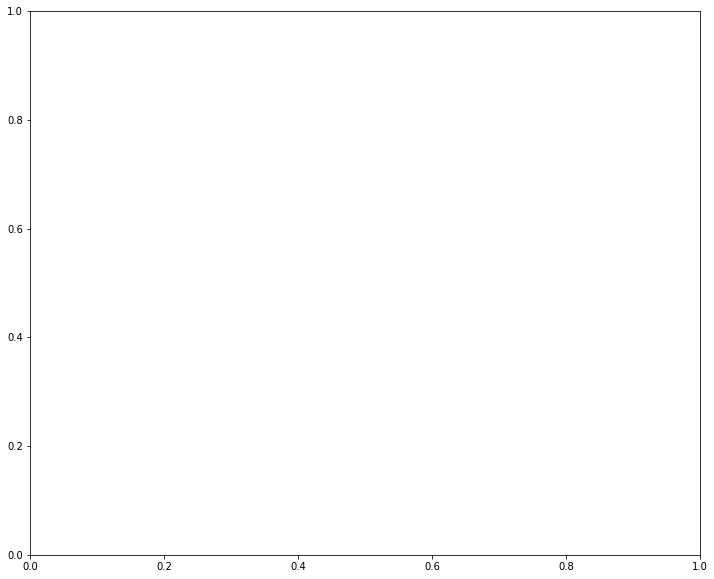

In [4]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(12,10))
plot_leverage_resid2(mod1Result, ax = ax)

### What Else Would You Do?

__QUESTION:__ What other graphs or descriptive summaries would you use to assess this model?  

__QUESTION:__ What might you do to improve on this model?

__QUESTION:__ How would you check for issues arising from 'endogeneity?'

### About Those Regression Coefficient p-values

You'll note from the summary output that there's a t-test for each regression coefficient that tests $H_0: \beta=0$.  These are NHST's, of course, and the validity of conclusions based on them depends on whether the model is _approximately_ correct, whether key assumptions are tenable, and so on. 

### Question:

Suppose one of the coefficients, say for q2, wasn't significantly different from zero based on this kind of NHST, while the coefficient for q6 was.  Would you say that the coefficients for q2 and q6 differ?

### What's Next?

We'll be moving on to other kinds of regression models, including some models for limited dependent variables, and models that can better cope with issues arising from multicollinearity.  But first we'll revisit bias and variance, and then we'll touch on what's called _regularization_.

